In [1]:
from backtest import do_simulation, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [2]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

## Some full simulations

100%|██████████| 231/231 [04:44<00:00,  1.23s/it]

Skipped 1 days due to incomplete data.


<Axes: xlabel='timestamp'>

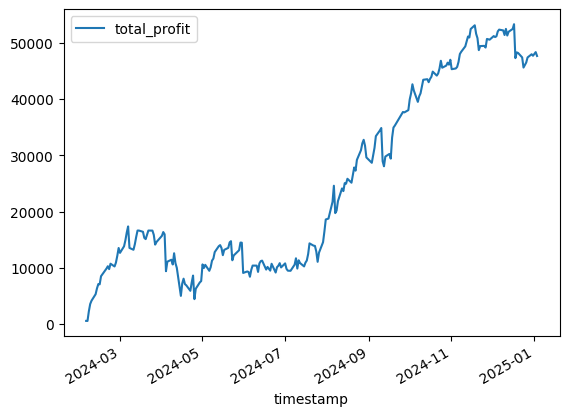

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 6),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(60),
    closing_strategy_last_n(30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

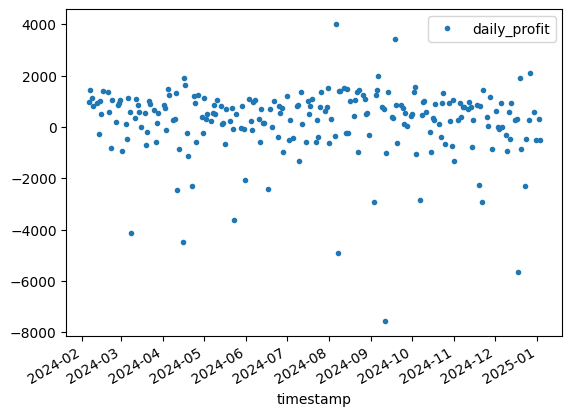

In [14]:
diff_df = profit_df.diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

Then a stop loss of around $2k sound like a good idea maybe?

100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Skipped 2 days due to incomplete data.


<Axes: xlabel='timestamp'>

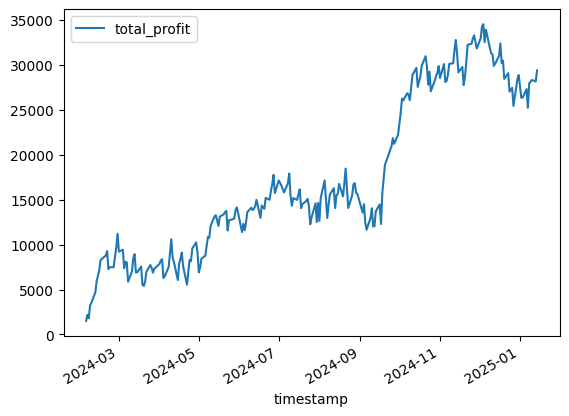

In [ ]:
profit_df, _ = do_simulation(
    datetime(2024, 2, 5),
    datetime(2025, 1, 15),
    asset,
    asset_data_service,
    options_data_service,
    opening_strategy_iron_condor_specific_minute_idx(2),
    closing_strategy_stoploss_or_last_n(2000, 30),
)

profit_df.plot()

<Axes: xlabel='timestamp'>

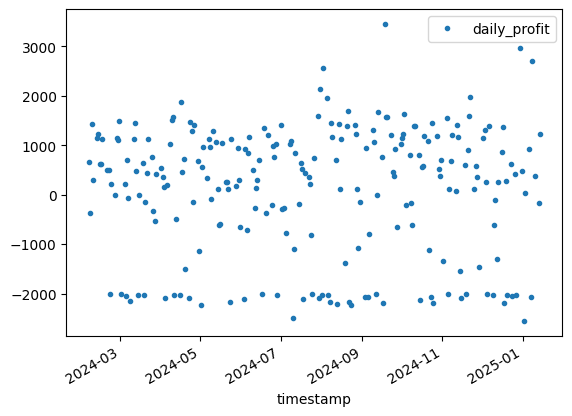

In [7]:
diff_df = profit_df.dropna().diff().rename(columns={"total_profit": "daily_profit"})
diff_df.plot(style='.')

In [8]:
f"Winning rate: {diff_df[diff_df['daily_profit'] > 0].shape[0] / diff_df.shape[0]:.2%}"

'Winning rate: 63.71%'

## Some potential P&L analysis based on daily position movement

In [3]:
# 1. either fetch anew:

# daily_movements = daily_potential_pnl(
#     datetime(2024, 2, 5),
#     datetime(2025, 1, 29),
#     asset,
#     asset_data_service,
#     options_data_service,
#     opening_strategy_iron_condor_specific_minute_idx(5),
# )

# import json
# with open("daily_movements_open5.json", "w") as f:
#     json.dump([m.tolist() for m in daily_movements], f)


# 2. or load from file:

import json

with open("daily_movements_open2.json", "r") as f:
    daily_movements = json.load(f)
    daily_movements = [np.array(l) for l in daily_movements]

In [4]:
daily_movements = [movement for movement in daily_movements if np.isnan(movement).all() == False]
len(daily_movements)

235

In [5]:
import matplotlib.pyplot as plt

In [6]:
EXLUDE_LAST_N = 60  # don't close positions in the last half hour

In [7]:
WAIT_FOR_N_BEFORE_STOPLOSS = 100  # 1 hour 40min

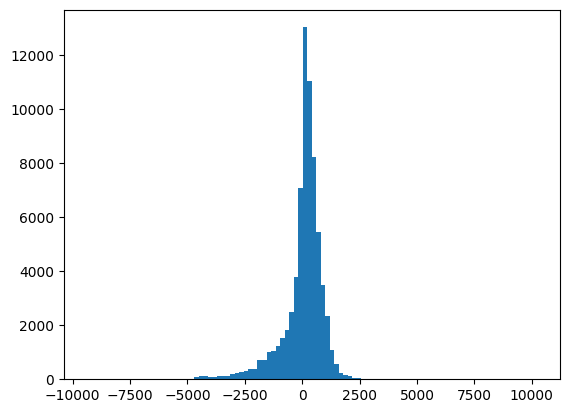

In [8]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

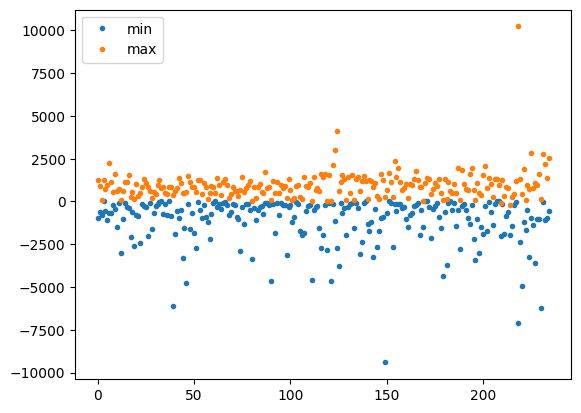

In [9]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [10]:
n_days = daily_min_max_df.shape[0]

In [12]:
profit_categories = [np.inf, 2000, 1750, 1600, 1500, 1250, 1200, 1000, 800, 750, 500, 400, 300, 250, 150, 100, 50]
loss_categories = [-50, -100, -150, -250, -300, -400, -500, -750, -800, -1000, -1200, -1250, -1500, -1600, -1750, -2000, -2500, -3000, -4000, -5000, -np.inf]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({inf: 0.0,
  2000: 0.04680851063829787,
  1750: 0.07234042553191489,
  1600: 0.08936170212765958,
  1500: 0.1276595744680851,
  1250: 0.25957446808510637,
  1200: 0.2851063829787234,
  1000: 0.4085106382978723,
  800: 0.5914893617021276,
  750: 0.6042553191489362,
  500: 0.7531914893617021,
  400: 0.8212765957446808,
  300: 0.8468085106382979,
  250: 0.8638297872340426,
  150: 0.9148936170212766,
  100: 0.9404255319148936,
  50: 0.9744680851063829},
 {-50: 0.9276595744680851,
  -100: 0.8553191489361702,
  -150: 0.7914893617021277,
  -250: 0.7063829787234043,
  -300: 0.6638297872340425,
  -400: 0.6170212765957447,
  -500: 0.5787234042553191,
  -750: 0.46382978723404256,
  -800: 0.44680851063829785,
  -1000: 0.3702127659574468,
  -1200: 0.3148936170212766,
  -1250: 0.31063829787234043,
  -1500: 0.2765957446808511,
  -1600: 0.2425531914893617,
  -1750: 0.2170212765957447,
  -2000: 0.1702127659574468,
  -2500: 0.13191489361702127,
  -3000: 0.08936170212765958,
  -4000: 0.0425531914893617,

In [13]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 \
                    if closing_strategy_limit_or_stoploss_after_n_or_last_m(
                        profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N
                    )(daily_movement) > 0 \
                    else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0,50.0
-50.0,0.289362,0.289362,0.289362,0.289362,0.293617,0.319149,0.323404,0.344681,0.400000,0.408511,0.544681,0.629787,0.693617,0.736170,0.842553,0.893617,0.953191
-100.0,0.319149,0.319149,0.319149,0.319149,0.319149,0.344681,0.348936,0.370213,0.425532,0.434043,0.570213,0.655319,0.706383,0.740426,0.846809,0.897872,0.953191
-150.0,0.344681,0.344681,0.344681,0.344681,0.344681,0.370213,0.374468,0.400000,0.455319,0.463830,0.587234,0.668085,0.723404,0.753191,0.851064,0.897872,0.953191
-250.0,0.391489,0.391489,0.391489,0.391489,0.391489,0.408511,0.412766,0.438298,0.493617,0.502128,0.621277,0.702128,0.753191,0.774468,0.863830,0.902128,0.953191
-300.0,0.408511,0.408511,0.408511,0.408511,0.408511,0.425532,0.429787,0.451064,0.506383,0.514894,0.629787,0.706383,0.757447,0.778723,0.872340,0.910638,0.957447
-400.0,0.434043,0.434043,0.434043,0.434043,0.434043,0.451064,0.455319,0.476596,0.527660,0.536170,0.646809,0.714894,0.761702,0.782979,0.872340,0.910638,0.961702
-500.0,0.459574,0.459574,0.459574,0.459574,0.459574,0.468085,0.472340,0.493617,0.544681,0.548936,0.659574,0.723404,0.770213,0.791489,0.880851,0.910638,0.961702
-750.0,0.536170,0.536170,0.536170,0.536170,0.536170,0.540426,0.544681,0.561702,0.604255,0.608511,0.693617,0.753191,0.787234,0.800000,0.885106,0.914894,0.961702
-800.0,0.540426,0.540426,0.540426,0.540426,0.540426,0.544681,0.548936,0.565957,0.608511,0.612766,0.697872,0.753191,0.787234,0.800000,0.885106,0.919149,0.961702
-1000.0,0.578723,0.578723,0.578723,0.578723,0.578723,0.582979,0.587234,0.600000,0.629787,0.634043,0.714894,0.765957,0.795745,0.808511,0.889362,0.923404,0.961702


<Axes: title={'center': 'Win rates for strat waiting for 100 minutes before stoploss'}>

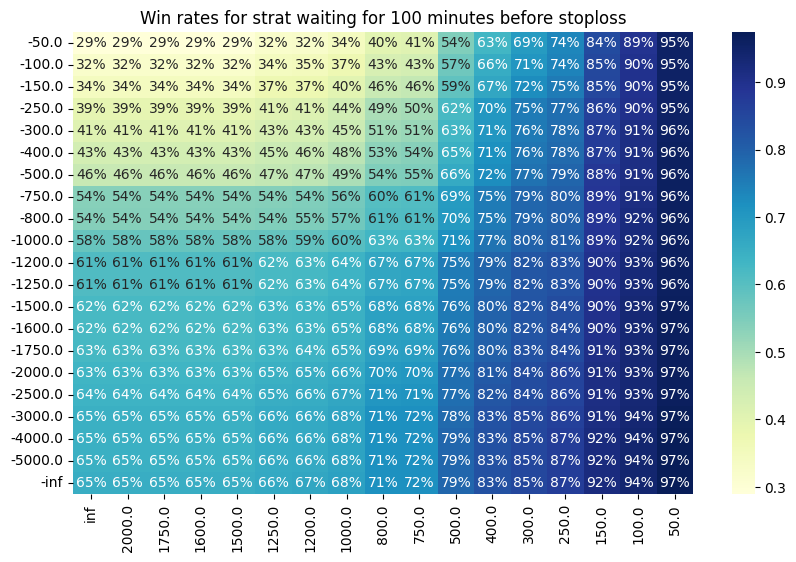

In [14]:
import seaborn as sns

# win rates

plt.figure(figsize=(10, 6))
plt.title(f"Win rates for strat waiting for {WAIT_FOR_N_BEFORE_STOPLOSS} minutes before stoploss")
sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

In [15]:
# profitable win rates according to Kelly criterion

kelly_profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            1 - abs(profit_cat / (profit_cat - loss_cat)) if not np.isinf(profit_cat) and not np.isinf(loss_cat) else np.nan
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

kelly_profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0,50.0
-50.0,NaN,0.024390,0.027778,0.030303,0.032258,0.038462,0.040000,0.047619,0.058824,0.062500,0.090909,0.111111,0.142857,0.166667,0.250000,0.333333,0.500000
-100.0,NaN,0.047619,0.054054,0.058824,0.062500,0.074074,0.076923,0.090909,0.111111,0.117647,0.166667,0.200000,0.250000,0.285714,0.400000,0.500000,0.666667
-150.0,NaN,0.069767,0.078947,0.085714,0.090909,0.107143,0.111111,0.130435,0.157895,0.166667,0.230769,0.272727,0.333333,0.375000,0.500000,0.600000,0.750000
-250.0,NaN,0.111111,0.125000,0.135135,0.142857,0.166667,0.172414,0.200000,0.238095,0.250000,0.333333,0.384615,0.454545,0.500000,0.625000,0.714286,0.833333
-300.0,NaN,0.130435,0.146341,0.157895,0.166667,0.193548,0.200000,0.230769,0.272727,0.285714,0.375000,0.428571,0.500000,0.545455,0.666667,0.750000,0.857143
-400.0,NaN,0.166667,0.186047,0.200000,0.210526,0.242424,0.250000,0.285714,0.333333,0.347826,0.444444,0.500000,0.571429,0.615385,0.727273,0.800000,0.888889
-500.0,NaN,0.200000,0.222222,0.238095,0.250000,0.285714,0.294118,0.333333,0.384615,0.400000,0.500000,0.555556,0.625000,0.666667,0.769231,0.833333,0.909091
-750.0,NaN,0.272727,0.300000,0.319149,0.333333,0.375000,0.384615,0.428571,0.483871,0.500000,0.600000,0.652174,0.714286,0.750000,0.833333,0.882353,0.937500
-800.0,NaN,0.285714,0.313725,0.333333,0.347826,0.390244,0.400000,0.444444,0.500000,0.516129,0.615385,0.666667,0.727273,0.761905,0.842105,0.888889,0.941176
-1000.0,NaN,0.333333,0.363636,0.384615,0.400000,0.444444,0.454545,0.500000,0.555556,0.571429,0.666667,0.714286,0.769231,0.800000,0.869565,0.909091,0.952381


<Axes: title={'center': 'Difference between win rates and Kelly criterion threshold'}>

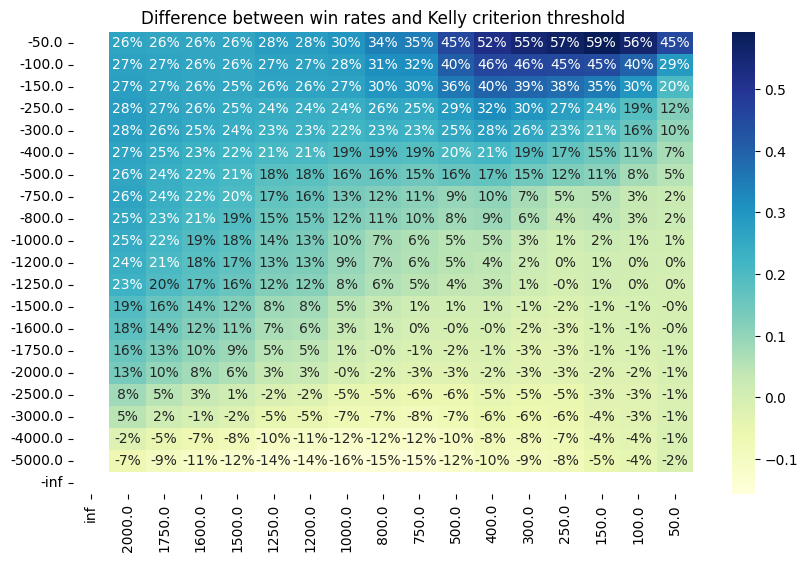

In [16]:
# difference between win rates and Kelly criterion

diff_profit_loss_matrix = profit_loss_matrix - kelly_profit_loss_matrix

plt.figure(figsize=(10, 6))
plt.title("Difference between win rates and Kelly criterion threshold")
sns.heatmap(diff_profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Not reaching limit or stoploss'}>

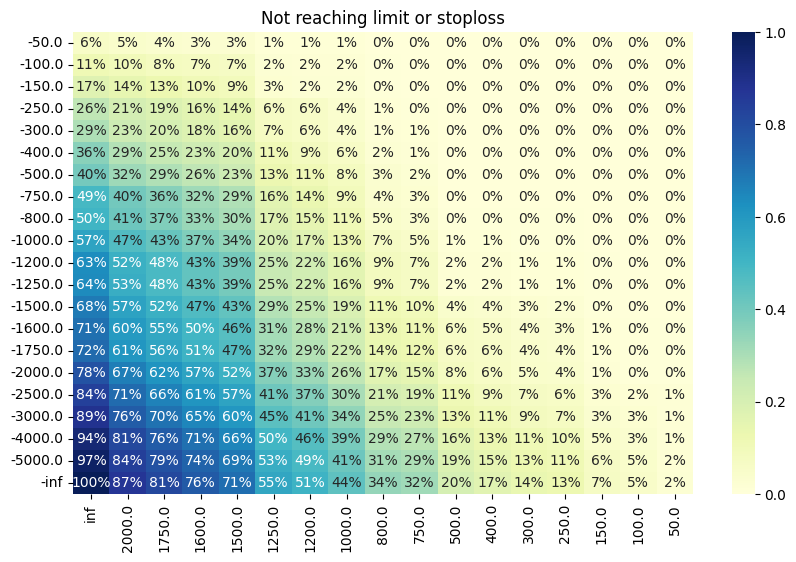

In [17]:
not_reaching_limit_or_stoploss_df = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if ((daily_movement >= loss_cat).all() & (daily_movement <= profit_cat).all()) else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(10, 6))
plt.title("Not reaching limit or stoploss")
sns.heatmap(not_reaching_limit_or_stoploss_df, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Total profit ($)'}>

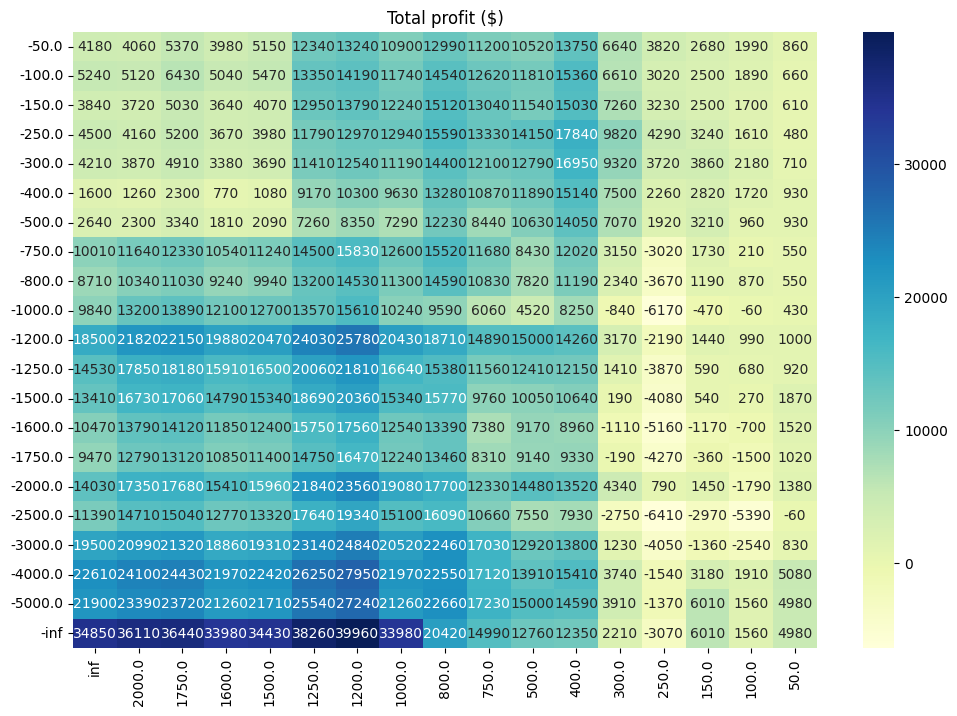

In [18]:
# total profit

total_profit_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 100, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Total profit ($)")
sns.heatmap(total_profit_matrix, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Cumulative profit for strategy: 1750 limit w/o stop loss'}>

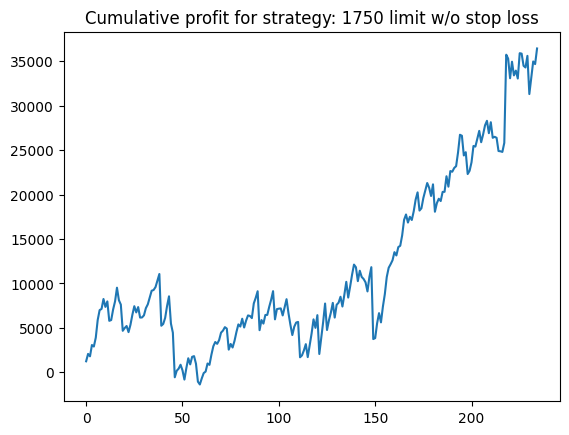

In [19]:
plt.title("Cumulative profit for strategy: 1750 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 400 limit w/ -400 stop loss'}>

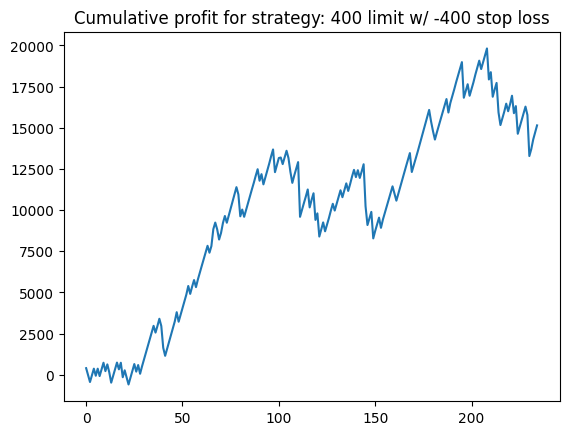

In [20]:
plt.title("Cumulative profit for strategy: 400 limit w/ -400 stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 150 limit w/o stop loss'}>

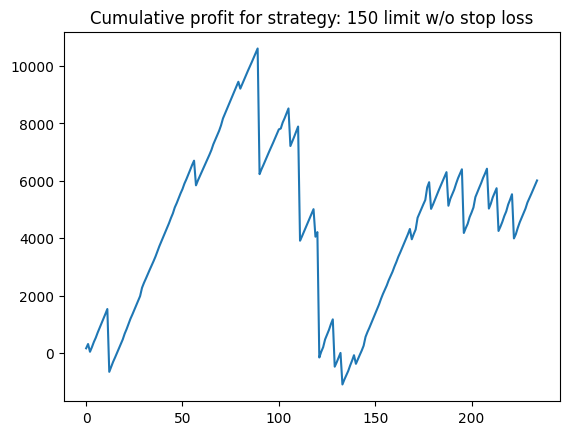

In [21]:
plt.title("Cumulative profit for strategy: 150 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 50 limit w/o stop loss'}>

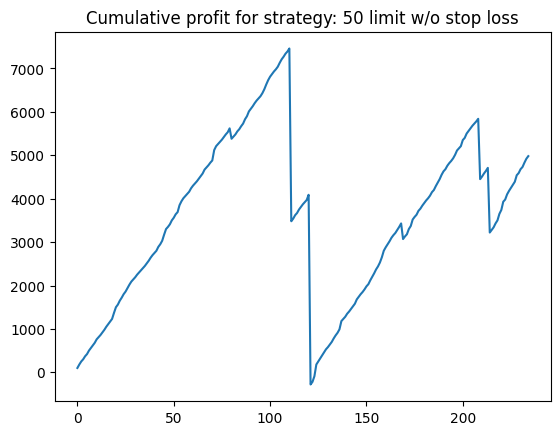

In [22]:
plt.title("Cumulative profit for strategy: 50 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        50, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Biggest losing days ($)'}>

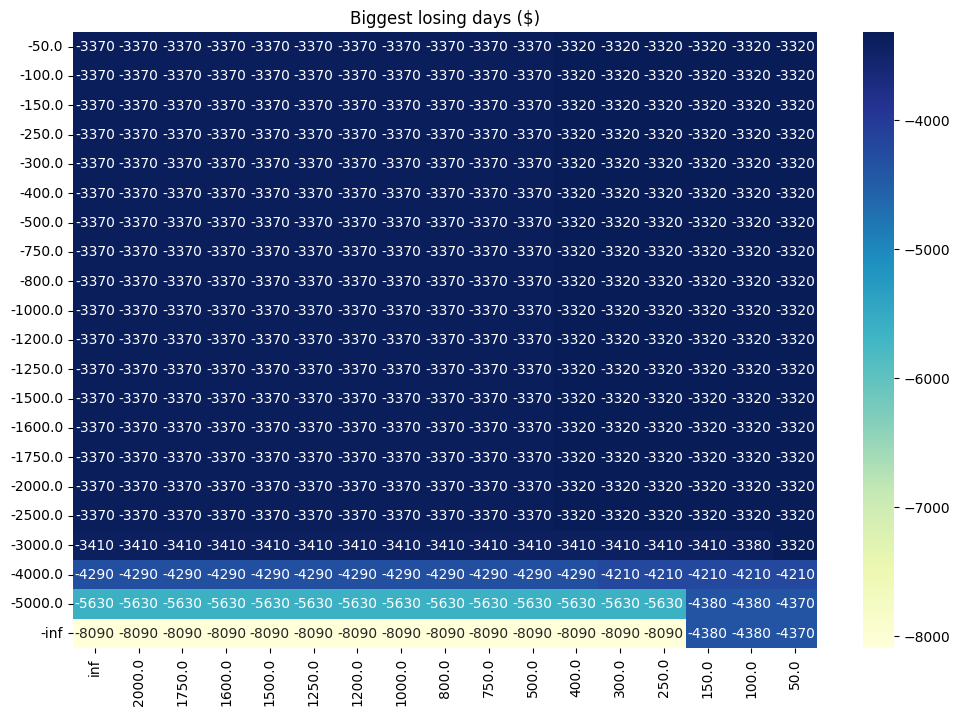

In [23]:
# biggest losing days

top_losers_df = pd.DataFrame(
    {
        profit_cat: [
            min(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Biggest losing days ($)")
sns.heatmap(top_losers_df, annot=True, fmt=".0f", cmap="YlGnBu")

111


<Axes: title={'center': 'Worst Day for 400 / -400 w/ waiting for 100min before stoploss'}>

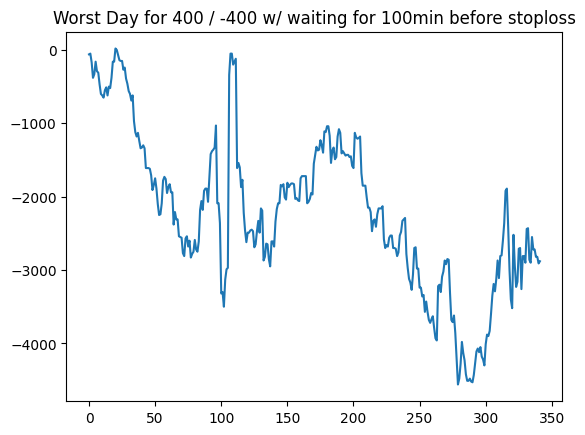

In [24]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title(f"Worst Day for 400 / -400 w/ waiting for {WAIT_FOR_N_BEFORE_STOPLOSS}min before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

index 230 is 7 jan 2025, 2 reports were released that day and i guess at 10:00 ET (17:00 BG) was one of them and brought the bears with it instantly... I guess that can be prevented

209


<Axes: title={'center': 'Worst Day for 400 / -400 w/o waiting before stoploss'}>

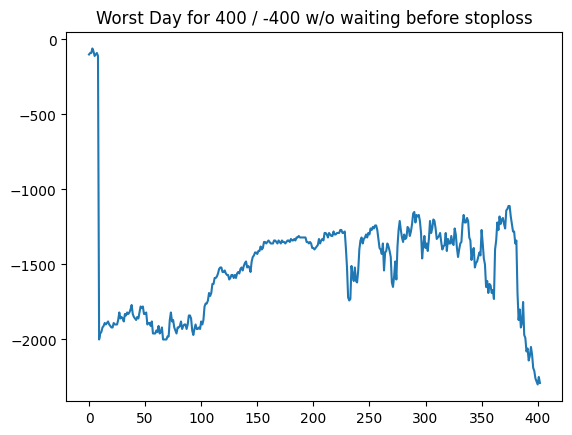

In [25]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, 0, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title("Worst Day for 400 / -400 w/o waiting before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

index 209 is 4 dec 2024... but nothing happened on this day... maybe I have wrong data (e.g. market open timestamp a bit earlier)? I will check this later

Losing Days for 50 / -inf w/o waiting before stoploss (excluding last 30min)
day index 111


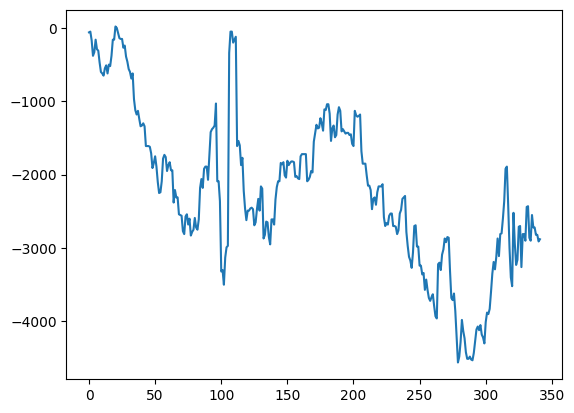

day index 121


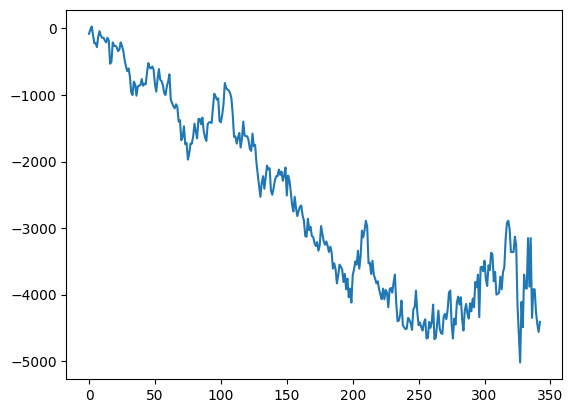

day index 169


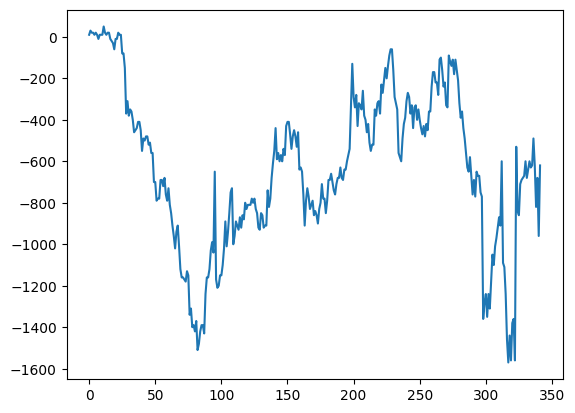

day index 209


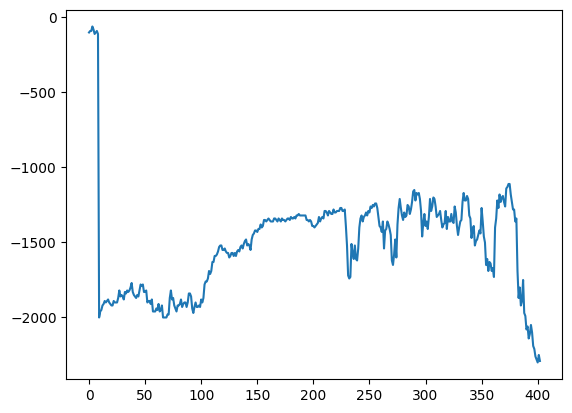

day index 214


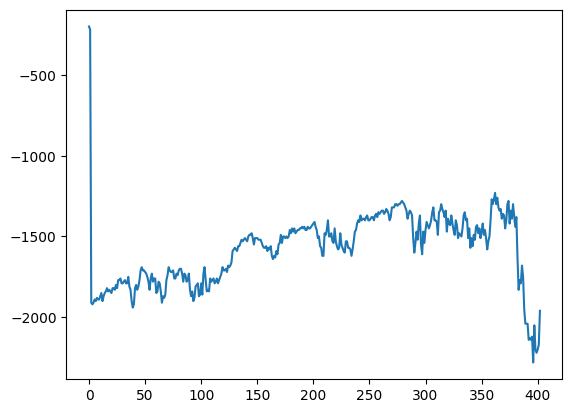

In [42]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(50, -np.inf, 0, 30)(daily_movement) for daily_movement in daily_movements])

[losing_days_idxs] = np.where(daily_pnl < 0)

print("Losing Days for 50 / -inf w/o waiting before stoploss (excluding last 30min)")
for idx in losing_days_idxs:
    sns.lineplot(daily_movements[idx])
    print("day index", idx)
    plt.show()


In [67]:

# longest negative streak

def count_losing_streak_subarray(arr):
    curr_idx = 0
    total_loss = 0
    while curr_idx < len(arr) and arr[curr_idx] < 0:
        total_loss += arr[curr_idx]
        curr_idx += 1
    return curr_idx, total_loss 


def longest_losing_streak_loss(arr):
    _, longest_negative_streak_money = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_money


def longest_losing_streak_days(arr):
    longest_negative_streak_days, _ = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_days

def max_losing_streak(arr):
    return min(
        count_losing_streak_subarray(arr[i:])[1]
        for i in range(len(arr))
    )


longest_losing_streak_days(daily_pnl), longest_losing_streak_loss(daily_pnl), max_losing_streak(daily_pnl)

(4, -1670.0000000000005, -2199.9999999999995)

<Axes: title={'center': "Longest losing streak (days) (don't wait until applying stoploss)"}>

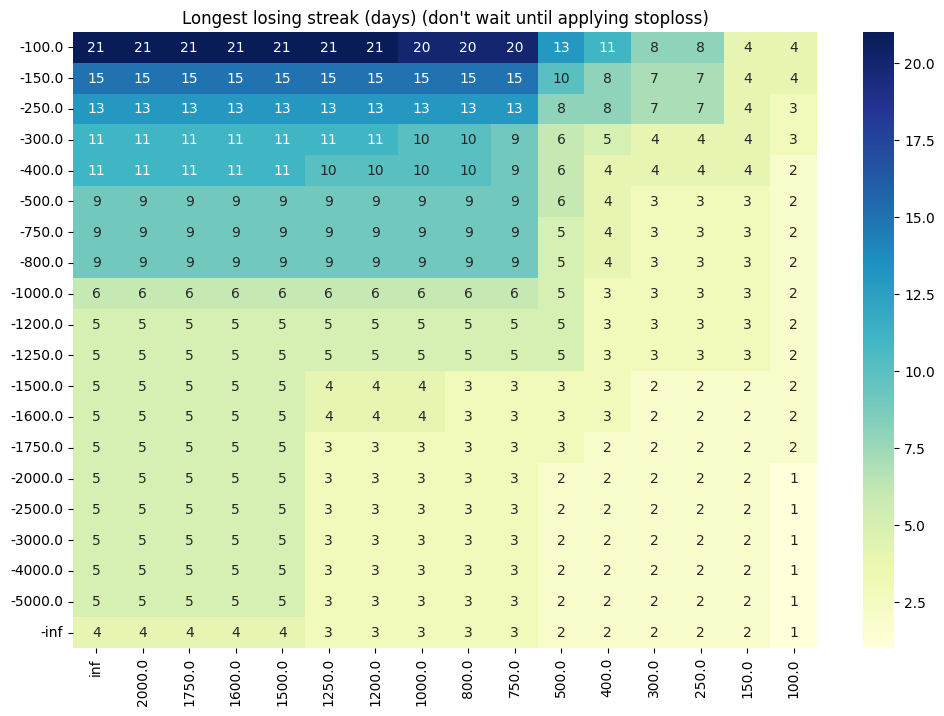

In [68]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak (days) (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Longest losing streak ($)  (don't wait until applying stoploss)"}>

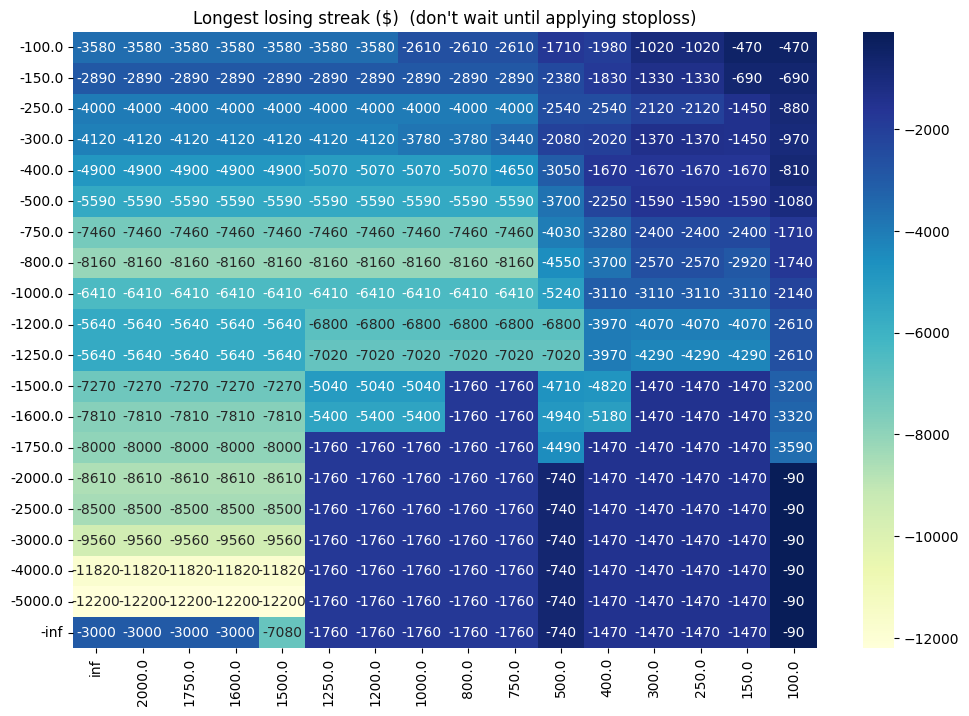

In [69]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Worst losing streak ($)  (don't wait until applying stoploss)"}>

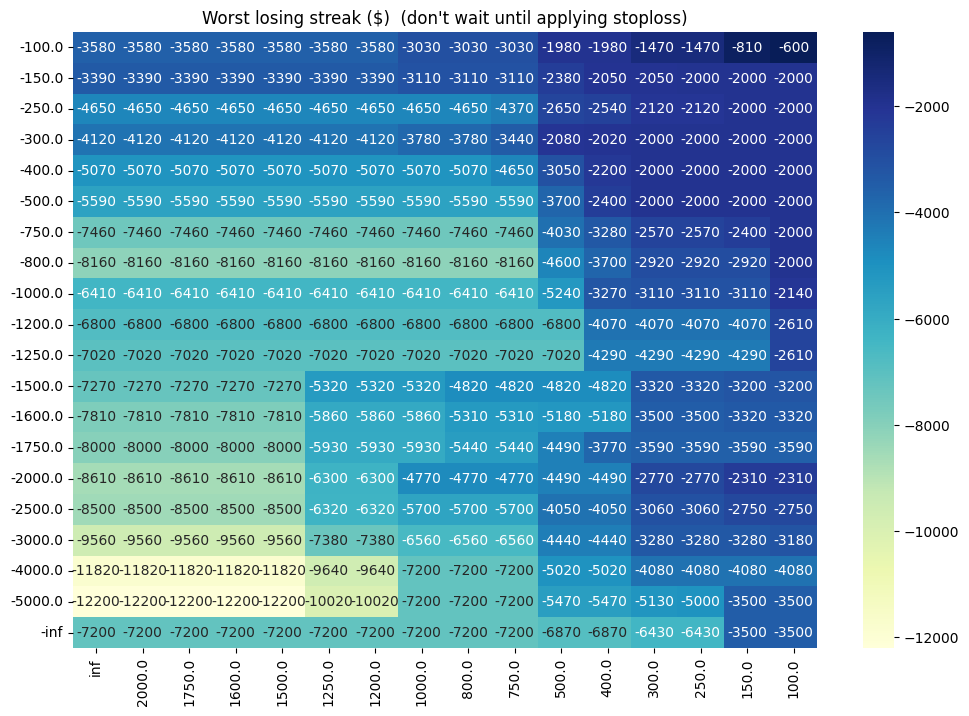

In [70]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Worst losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak (days) (wait for 100min before applying stoploss)'}>

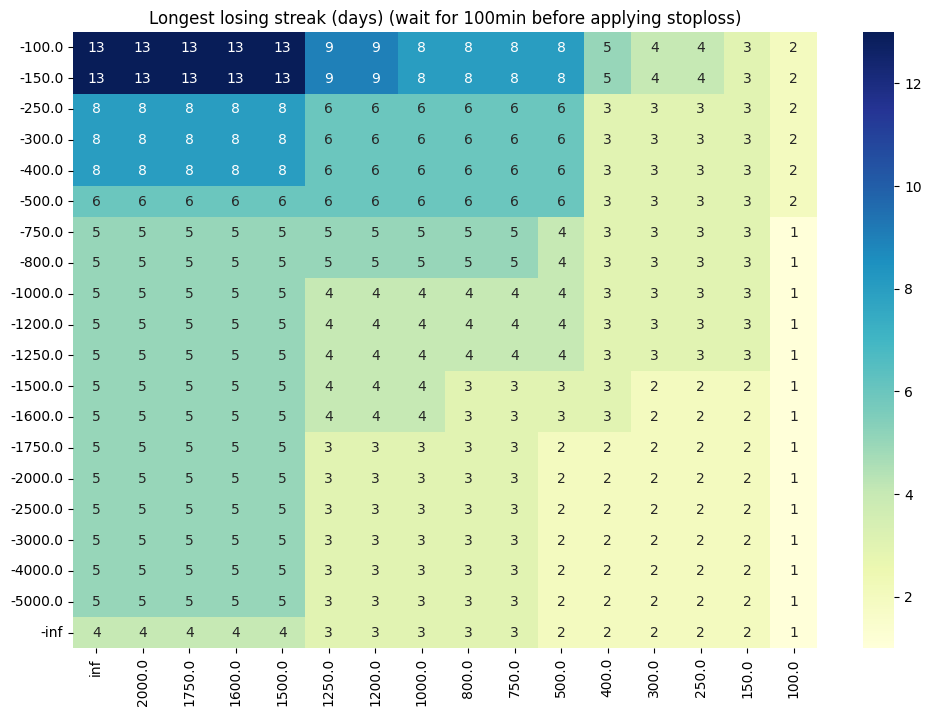

In [71]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak (days) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak ($) (wait for 100min before applying stoploss)'}>

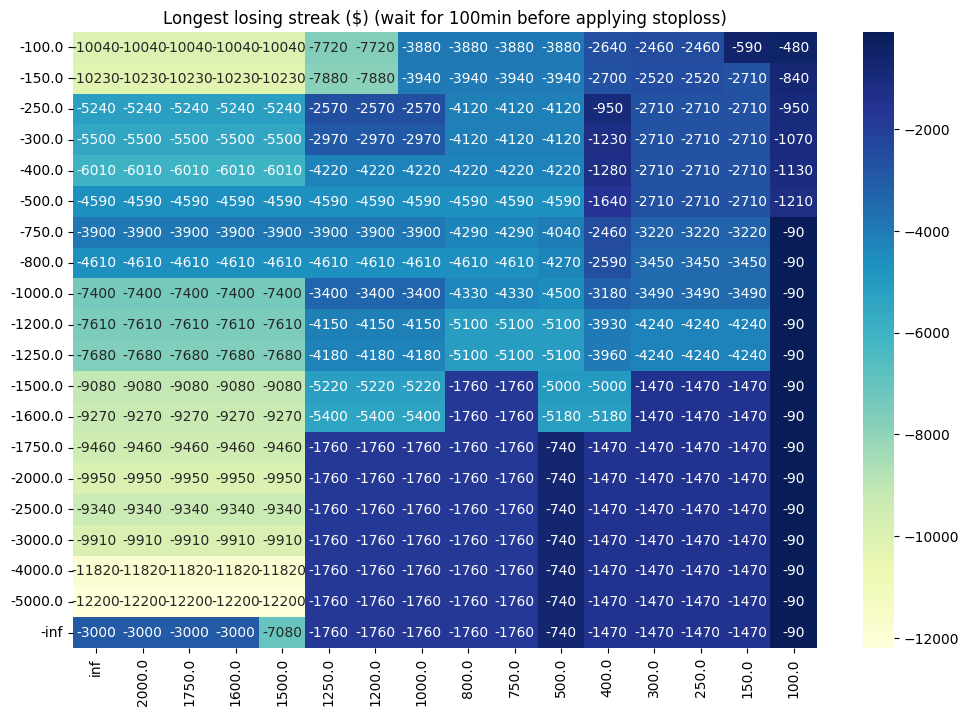

In [72]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Worst losing streak ($) (wait for 100min before applying stoploss)'}>

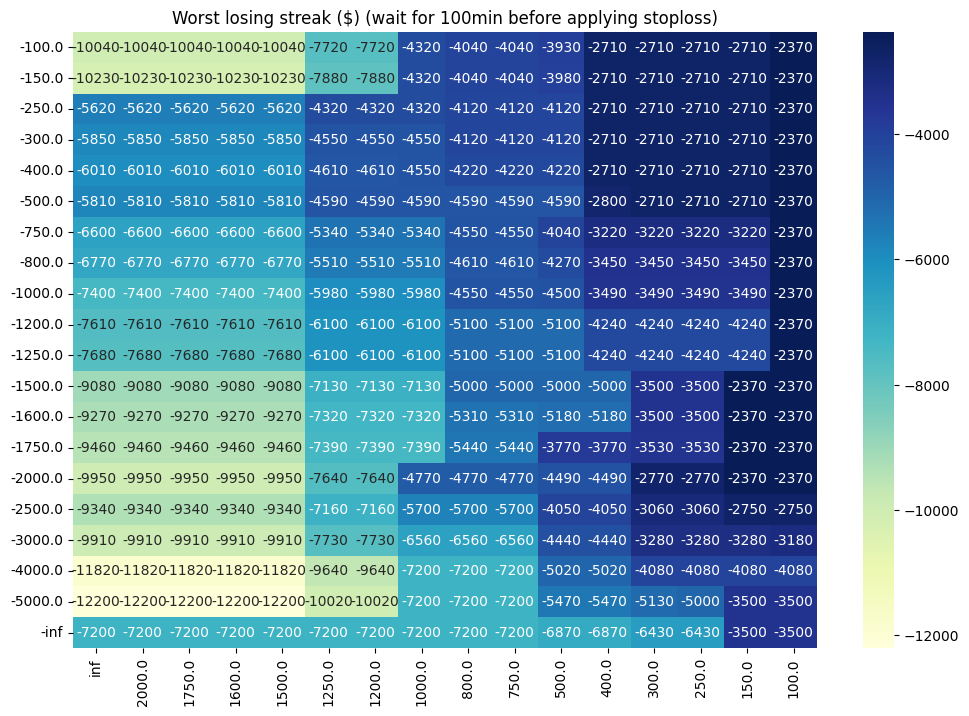

In [73]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Worst losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

In [74]:
def strategy_limit_reach_minute(arr, limit, stoploss, wait_n_before_stoploss, last_n):
    for idx, value in enumerate(arr[:-last_n]):
        if value >= limit:
            return idx
        if value <= stoploss and idx >= wait_n_before_stoploss:
            return -1
    return len(arr) - last_n

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/ -400 stop loss'}, ylabel='Count'>

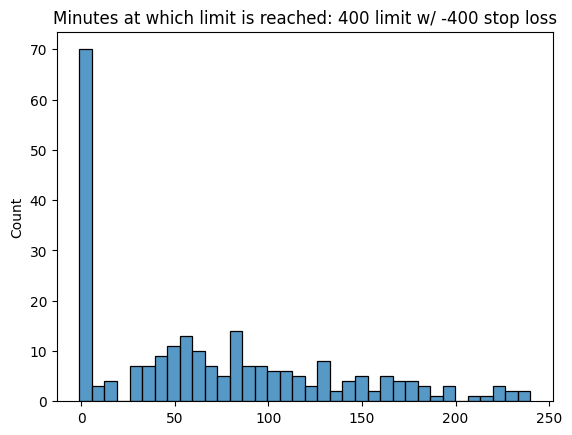

In [75]:
plt.title("Minutes at which limit is reached: 400 limit w/ -400 stop loss")

limit_400_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_400_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 1750 limit w/o stop loss'}, ylabel='Count'>

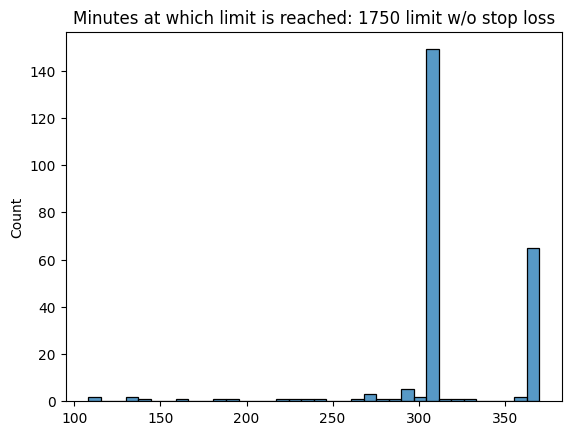

In [76]:
plt.title("Minutes at which limit is reached: 1750 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 200 limit w/o stop loss'}, ylabel='Count'>

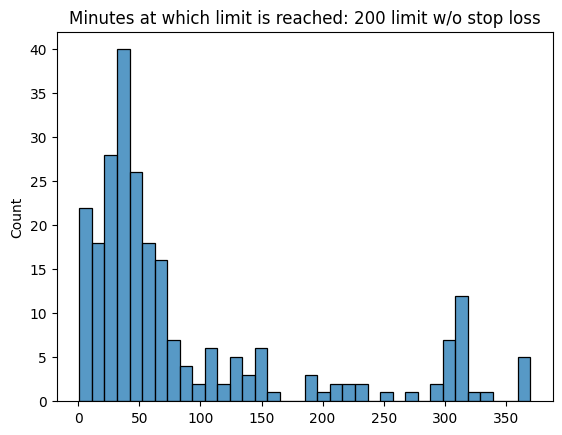

In [77]:
plt.title("Minutes at which limit is reached: 200 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 200, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/o stop loss'}, ylabel='Count'>

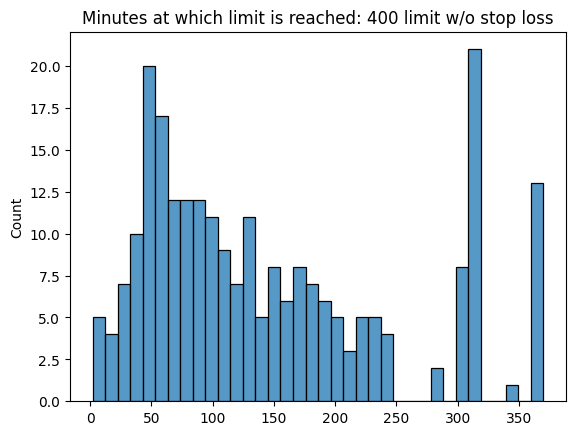

In [78]:
plt.title("Minutes at which limit is reached: 400 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 400, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 150 limit w/o stop loss'}, ylabel='Count'>

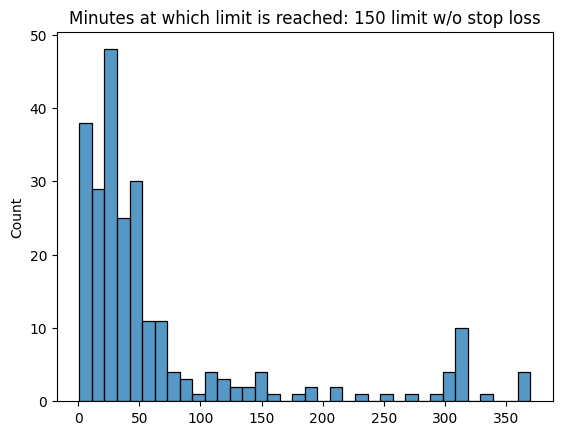

In [79]:
plt.title("Minutes at which limit is reached: 150 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)